# Capstone Week 2 by Thomas Jensen (claude.ai help)

Just run all cell at once

This notebook explores different implementations of a simple neural network to solve the XOR problem.

## Overview and Conclusions:
1.  **NumPy Implementation**: Manual forward and backward passes, and gradient descent using NumPy manually.


*   I had (as predicted in 'Deep Learning Basics with PyTorch') problems with 'dead' RELUs.
*   Assisted by AI I used he/xavier initialization and (in the forward calculation) activation == 'leaky_relu'.
*   I still had problems without batching: very slow progress - (as predicted in 'Deep Learning Basics with PyTorch') - so assisted by AI I used batching. I did not integrate insights from week 1 concerning improved gradient descent.
*   With averaging over the batches, learning rate 0.2, he initializing and 'leaky relu' the nn seems to work

2.  **PyTorch Manual Loop**: Transitioning to PyTorch with a manual training loop and autograd for gradient calculations.
*   With 'manual forward' and PyTorch for gradients I get Accuracy as follows: with 16 neurons in layer1 a accuracy = 0.988  and with only 2 neurons accuracy = 0.82´
3.  **PyTorch `nn.Module` (Semi-Manual)**: Defining a custom neural network using PyTorch's `nn.Module`.
*   PyTorch Manual Loop seems to work well (here with 16 hidden units)

4.  **PyTorch `nn.Sequential` (Fully Automated)**: Leveraging PyTorch's `nn.Sequential` for a streamlined and automated model definition and training process.
*   PyTorch nn.Sequential works well and improves fast - especially at the first 100 epochs



# 1.  **NumPy Implementation**: Manual forward and backward passes, and gradient descent using NumPy manually.

We generate data points and 'targets': test

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(78)

# Generate data points
# x ~ Uniform([-1, 1]^2) means both x1 and x2 are uniformly distributed in [-1, 1]
n_points = 1000
x1 = np.random.uniform(-1, 1, n_points)
x2 = np.random.uniform(-1, 1, n_points)

# Stack them to create our input data (2, n_points)
X = np.column_stack([x1, x2]).T

# Generate labels using the XOR rule
# y = 1 if x1 * x2 < 0, else y = 0
y = (x1 * x2 < 0).astype(int)

def sigmoid(z):
      return 1 / (1 + np.exp(-z))

Initialize W1, b1, W2, b2. Values from nn.backpropagation.pdf

In [133]:
"""
# First layer weights (2x2 matrix)
W1 = np.array([[1, -2],
               [0.5, 1]], dtype=np.float64)

# First layer bias (2x1 column vector)
b1 = np.array([[0],
               [0]], dtype=np.float64)

# Second layer weights (1x2 matrix)
W2 = np.array([[1, -1]], dtype=np.float64)

# Second layer bias (scalar, but often kept as array for consistency)
b2 = np.array([[0]], dtype=np.float64) # Ensure b2 is a float array with shape (1,1)
"""

'\n# First layer weights (2x2 matrix)\nW1 = np.array([[1, -2],\n               [0.5, 1]], dtype=np.float64)\n\n# First layer bias (2x1 column vector)\nb1 = np.array([[0],\n               [0]], dtype=np.float64)\n\n# Second layer weights (1x2 matrix)\nW2 = np.array([[1, -1]], dtype=np.float64)\n\n# Second layer bias (scalar, but often kept as array for consistency)\nb2 = np.array([[0]], dtype=np.float64) # Ensure b2 is a float array with shape (1,1)\n'

In [134]:
# Implemented he/xavier initialization after problems with getting progress
# when training
def initialize_parameters(input_size, hidden_size, output_size, method='he'):
    """
    Initialize parameters with proper scaling

    Args:
        input_size: number of input features (d=2 for XOR)
        hidden_size: number of hidden neurons (h=2 in your case)
        output_size: number of outputs (1 for binary classification)
        method: 'he' for ReLU, 'xavier' for sigmoid

    Returns:
        W1, b1, W2, b2
    """
    np.random.seed(88)  # For reproducibility

    if method == 'he':
        # He initialization for ReLU
        W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
    elif method == 'xavier':
        # Xavier initialization for sigmoid
        W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / (input_size + hidden_size))
        W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / (hidden_size + output_size))
    else:
        raise ValueError("method must be 'he' or 'xavier'")

    # Biases initialized to zero (common practice)
    #b1 = np.zeros((hidden_size, 1))
    b1 = np.random.randn(hidden_size, 1) * 0.01  # Small positive bias
    b2 = np.zeros((output_size, 1))


    return W1, b1, W2, b2

Define the forward pass function

In [135]:
# Implemented 'leaky_relu' trying to avoid 'dead RELU's'
def forward_pass_single(x_point, y_point, W1, b1, W2, b2, activation='relu'):
    """
    Forward pass for a SINGLE data point

    Args:
        x_point: shape (2, 1) - one input point [x1, x2]
        y_point: scalar or shape (1,) - one label (0 or 1)
        W1, b1, W2, b2: network parameters

    Returns:
        a1: pre-activation of hidden layer (2, 1)
        h1: post-activation of hidden layer (2, 1)
        f: final output (scalar)
        L: loss (scalar)
    """
    # Forward pass
    a1 = W1 @ x_point + b1          # (2, 2) @ (2, 1) + (2, 1) = (2, 1)


    if activation == 'leaky_relu': # leaky relu to keep the neurons alive
      alpha = 0.01
      h1 = np.where(a1 > 0, a1, alpha * a1)
    elif activation == 'relu':
        h1 = np.maximum(0, a1)       # (2, 1)
    elif activation == 'sigmoid':
        h1 = sigmoid(a1)             # (2, 1)
    else:
        raise ValueError("Choose 'relu' or 'sigmoid' or 'leaky_relu'")

    f = W2 @ h1 + b2                 # (1, 2) @ (2, 1) + (1, 1) = (1, 1)
    f = f[0, 0]                      # Extract scalar from array

    # Loss: mean squared error (for single point, just squared error)
    L = 0.5 * (f - y_point)**2

    return a1, h1, f, L

In [136]:
"""# Test with the first data point
x_test = X[:, 0:1]  # Shape (2, 1) - first point
y_test = y[0]       # Scalar - first label

print("Testing single point forward pass:")
print(f"Input shape: {x_test.shape}")
print(f"Input x1={x_test[0, 0]:.3f}, x2={x_test[1, 0]:.3f}")
print(f"Label: {y_test}")

a1, h1, f, L = forward_pass_single(x_test, y_test, W1, b1, W2, b2, activation='relu')

print(f"\nHidden layer pre-activation a1:\n{a1}")
print(f"Hidden layer post-activation h1:\n{h1}")
print(f"Output f: {f:.4f}")
print(f"Loss L: {L:.4f}")
"""

'# Test with the first data point\nx_test = X[:, 0:1]  # Shape (2, 1) - first point\ny_test = y[0]       # Scalar - first label\n\nprint("Testing single point forward pass:")\nprint(f"Input shape: {x_test.shape}")\nprint(f"Input x1={x_test[0, 0]:.3f}, x2={x_test[1, 0]:.3f}")\nprint(f"Label: {y_test}")\n\na1, h1, f, L = forward_pass_single(x_test, y_test, W1, b1, W2, b2, activation=\'relu\')\n\nprint(f"\nHidden layer pre-activation a1:\n{a1}")\nprint(f"Hidden layer post-activation h1:\n{h1}")\nprint(f"Output f: {f:.4f}")\nprint(f"Loss L: {L:.4f}")\n'

Define the backward pass function

In [137]:
def backward_pass_single(x_point, y_point, a1, h1, f, W1, W2, activation='relu'):
    """
    Backward pass for a SINGLE data point

    Args:
        x_point: shape (2, 1) - the input point
        y_point: scalar - the true label
        a1: shape (2, 1) - pre-activation from forward pass
        h1: shape (2, 1) - post-activation from forward pass
        f: scalar - network output from forward pass
        W1, W2: current weights
        activation: 'relu' or 'sigmoid'

    Returns:
        dW1, db1, dW2, db2: gradients for all parameters
    """

    # Compute activation derivative
    if activation == 'leaky_relu':
      alpha = 0.01
      activation_derivative = np.where(a1 > 0, 1.0, alpha)
    elif activation == 'relu':
        # Derivative of ReLU: 1 if a1 > 0, else 0
        activation_derivative = (a1 > 0).astype(float)  # (2, 1)
    elif activation == 'sigmoid':
        # Derivative of sigmoid: σ(a1) * (1 - σ(a1))
        activation_derivative = h1 * (1 - h1)  # (2, 1)
    else:
        raise ValueError("Choose 'relu' or 'sigmoid' or 'leaky_relu'") # Changed error message for consistency

    # Gradient of loss with respect to output
    # L = 0.5 * (f - y)^2, so dL/df = (f - y)
    df = f - y_point  # scalar

    # Gradients for W2, b2
    # f = W2 @ h1 + b2, so df/dW2 = h1^T
    dW2 = df * h1.T  # scalar * (1, 2) = (1, 2)
    db2 = np.array([[df]])  # Make it (1, 1) to match b2 shape
    # Backprop into hidden layer
    # df/dh1 = W2^T (transposed)
    dh1 = W2.T * df  # (2, 1) * scalar = (2, 1)

    # Apply activation derivative (chain rule!)
    da1 = dh1 * activation_derivative  # (2, 1) element-wise multiply

    # Gradients for W1, b1
    # a1 = W1 @ x + b1, so da1/dW1 = x^T
    dW1 = da1 @ x_point.T  # (2, 1) @ (1, 2) = (2, 2)
    db1 = da1              # (2, 1)

    return dW1, db1, dW2, db2

In [138]:
"""# Test backward pass with the same point
dW1, db1, dW2, db2 = backward_pass_single(x_test, y_test, a1, h1, f, W1, W2, activation='relu')

print("\nGradients:")
print(f"dW1 shape: {dW1.shape}, values:\n{dW1}")
print(f"db1 shape: {db1.shape}, values:\n{db1}")
print(f"dW2 shape: {dW2.shape}, values:\n{dW2}")
print(f"db2: {db2}")
"""

'# Test backward pass with the same point\ndW1, db1, dW2, db2 = backward_pass_single(x_test, y_test, a1, h1, f, W1, W2, activation=\'relu\')\n\nprint("\nGradients:")\nprint(f"dW1 shape: {dW1.shape}, values:\n{dW1}")\nprint(f"db1 shape: {db1.shape}, values:\n{db1}")\nprint(f"dW2 shape: {dW2.shape}, values:\n{dW2}")\nprint(f"db2: {db2}")\n'

Define the gradient descend function

In [139]:
def gradient_descent_single(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate=0.1):
    """
    Update parameters using gradient descent

    Args:
        W1, b1, W2, b2: current parameters
        dW1, db1, dW2, db2: gradients
        learning_rate: how big a step to take

    Returns:
        Updated parameters
    """
    W1_new = W1 - learning_rate * dW1
    b1_new = b1 - learning_rate * db1
    W2_new = W2 - learning_rate * dW2
    b2_new = b2 - learning_rate * db2

    return W1_new, b1_new, W2_new, b2_new

In [140]:
def train_network(X, y, W1, b1, W2, b2, learning_rate=0.1, num_epochs=100, activation='relu'):
    """
    Train the neural network on the dataset

    Args:
        X: shape (2, n_points) - all input data
        y: shape (n_points,) - all labels
        W1, b1, W2, b2: initial parameters
        learning_rate: step size for updates
        num_epochs: how many times to go through the entire dataset
        activation: 'relu' or 'sigmoid'

    Returns:
        Trained parameters and loss history
    """
    n_points = X.shape[1]
    loss_history = []  # Track loss over time

    # Make copies so we don't modify the originals
    W1_trained = W1.copy()
    b1_trained = b1.copy()
    W2_trained = W2.copy()
    b2_trained = b2.copy()

    print(f"Starting training for {num_epochs} epochs with {n_points} points per epoch...")
    print(f"Total updates: {num_epochs * n_points}\n")

    for epoch in range(num_epochs):
        epoch_loss = 0.0  # Accumulate loss for this epoch

        # Loop through each data point
        for i in range(n_points):
            # Get single point (2, 1) and single label
            # By using i:i+1, you force NumPy to keep the input
            # as a proper column matrix, not a flattened vector.
            x_point = X[:, i:i+1]
            y_point = y[i]

            # Forward pass
            a1, h1, f, L = forward_pass_single(
                x_point, y_point,
                W1_trained, b1_trained, W2_trained, b2_trained,
                activation
            )

            # Backward pass
            dW1, db1, dW2, db2 = backward_pass_single(
                x_point, y_point, a1, h1, f,
                W1_trained, W2_trained,
                activation
            )

            # Update parameters
            W1_trained, b1_trained, W2_trained, b2_trained = gradient_descent_single(
                W1_trained, b1_trained, W2_trained, b2_trained,
                dW1, db1, dW2, db2,
                learning_rate
            )

            epoch_loss += L

        # Average loss for this epoch
        avg_loss = epoch_loss / n_points
        loss_history.append(avg_loss)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    print("\nTraining complete!")
    return W1_trained, b1_trained, W2_trained, b2_trained, loss_history

In [141]:
def train_network_batch(X, y, W1, b1, W2, b2, learning_rate=0.5, num_epochs=5000, activation='leaky_relu'):
      n_points = X.shape[1]
      loss_history = []

      for epoch in range(num_epochs):
          # Accumulate gradients over entire batch
          dW1_batch = np.zeros_like(W1)
          db1_batch = np.zeros_like(b1)
          dW2_batch = np.zeros_like(W2)
          db2_batch = np.zeros_like(b2)
          epoch_loss = 0.0

          for i in range(n_points):
              x_point = X[:, i:i+1]
              y_point = y[i]

              a1, h1, f, L = forward_pass_single(x_point, y_point, W1, b1, W2, b2, activation)
              dW1, db1, dW2, db2 = backward_pass_single(x_point, y_point, a1, h1, f, W1, W2, activation)

              # Accumulate gradients
              dW1_batch += dW1
              db1_batch += db1
              dW2_batch += dW2
              db2_batch += db2
              epoch_loss += L

          # Average gradients and update once per epoch
          W1 = W1 - learning_rate * dW1_batch / n_points
          b1 = b1 - learning_rate * db1_batch / n_points
          W2 = W2 - learning_rate * dW2_batch / n_points
          b2 = b2 - learning_rate * db2_batch / n_points

          avg_loss = epoch_loss / n_points
          loss_history.append(avg_loss)

          if (epoch + 1) % 100 == 0:
              print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

      return W1, b1, W2, b2, loss_history

In [142]:
# Initialize with He initialization (for ReLU)
W1_he, b1_he, W2_he, b2_he = initialize_parameters(
    input_size=2,
    hidden_size=8,
    output_size=1,
    method='he'
)

In [143]:
"""
# Train the network
W1_trained, b1_trained, W2_trained, b2_trained, loss_history = train_network(
    X, y, W1_he, b1_he, W2_he, b2_he,
    learning_rate=0.5,
    num_epochs=50,  # Start small
    activation='leaky_relu'
)
"""

"\n# Train the network\nW1_trained, b1_trained, W2_trained, b2_trained, loss_history = train_network(\n    X, y, W1_he, b1_he, W2_he, b2_he,\n    learning_rate=0.5,\n    num_epochs=50,  # Start small\n    activation='leaky_relu'\n)\n"

In [144]:
# Try Train the network with he and batch
W1_trained, b1_trained, W2_trained, b2_trained, loss_history = train_network_batch(
    X, y, W1_he, b1_he, W2_he, b2_he,
    learning_rate=0.2,
    num_epochs=500,  # Start small with 50. Used 5000
    activation='leaky_relu'
)

Epoch 100/500, Loss: 0.039492
Epoch 200/500, Loss: 0.037243
Epoch 300/500, Loss: 0.036063
Epoch 400/500, Loss: 0.035074
Epoch 500/500, Loss: 0.034196


## Conclusion: With averaging over the batches, learning rate 0.2, 'he' initializing and 'leaky relu' the nn seems to work (when using 5000 epochs)

# 2. **PyTorch Manual Loop**: Transitioning to PyTorch with a manual training loop and autograd for gradient calculations.

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(78)

# Generate data points
# x ~ Uniform([-1, 1]^2) means both x1 and x2 are uniformly distributed in [-1, 1]
n_points = 1000
x1 = np.random.uniform(-1, 1, n_points)
x2 = np.random.uniform(-1, 1, n_points)

# Stack them to create our input data (2, n_points)
X = np.column_stack([x1, x2]).T

# Generate labels using the XOR rule
# y = 1 if x1 * x2 < 0, else y = 0
y = (x1 * x2 < 0).astype(int)

# Code from chapter 7 in the dl.html book (except X and y)

import torch  # core tensor/autograd library
import torch.nn.functional as F  # functional ops: loss and activation
from sklearn.datasets import make_moons  # toy dataset generator
from sklearn.model_selection import train_test_split  # train/test split

# Data
torch.manual_seed(0)  # fix RNG for reproducibility
X, y = X.T, y.T # I defined X and y at the top of the cell
X_tr, X_te, y_tr, y_te = train_test_split(  # stratified split
    X, y, test_size=0.25, random_state=42, stratify=y)
X_tr = torch.tensor(X_tr, dtype=torch.float32)  # train features tensor
X_te = torch.tensor(X_te, dtype=torch.float32)  # test features tensor
y_tr = torch.tensor(y_tr, dtype=torch.long)  # train labels (class indices)
y_te = torch.tensor(y_te, dtype=torch.long)  # test labels (class indices)

# Two-layer MLP params (tensors with grads)
W1 = torch.randn(2, 16, requires_grad=True)  # layer1 weights (2->16)
b1 = torch.zeros(16, requires_grad=True)  # layer1 bias (16,)
W2 = torch.randn(16, 2, requires_grad=True)  # layer2 weights (16->2)
b2 = torch.zeros(2, requires_grad=True)  # layer2 bias (2,)

# Two-layer MLP params (tensors with grads)
"""W1 = torch.randn(2, 2, requires_grad=True)  # layer1 weights (2->2)
b1 = torch.zeros(2, requires_grad=True)  # layer1 bias (2,)
W2 = torch.randn(2, 2, requires_grad=True)  # layer2 weights (2->2)
b2 = torch.zeros(2, requires_grad=True)  # layer2 bias (2,)"""

# Light init scaling without tracking gradients
with torch.no_grad():
    W1.mul_(0.5)  # halve initial scale
    W2.mul_(0.5)  # halve initial scale

def forward(X):  # manual forward pass
    h = torch.relu(X @ W1 + b1)  # hidden activations after ReLU
    return h @ W2 + b2  # logits for 2 classes

# Manual SGD loop
losses = []  # collect losses for plotting
for i in range(300):  # epochs

    logits = forward(X_tr)  # compute logits on train set
    loss = F.cross_entropy(logits, y_tr)  # CE loss on train set
    for p in (W1, b1, W2, b2):  # iterate parameters
        if p.grad is not None:  # clear stale grads
            p.grad.zero_()
    loss.backward()  # backprop gradients
    with torch.no_grad():  # parameter update (no grad)
        for p in (W1, b1, W2, b2):
            p -= 0.1 * p.grad  # SGD step (lr=0.1)
    if (i + 1) % 10 == 0:
            # Detach to avoid warning about converting a tensor requiring grad
            losses.append(loss.detach().item())
    if (i + 1) % 10 == 0:
              print(f"Epoch {i + 1}/300, Loss: {losses[i // 10]:.6f}")

# Evaluate accuracy on test set
with torch.no_grad():
    acc = float((forward(X_te).argmax(1) == y_te).float().mean())  # test accuracy
print(f"Accuracy: {acc:.3f}")

Epoch 10/300, Loss: 0.747642
Epoch 20/300, Loss: 0.668209
Epoch 30/300, Loss: 0.613469
Epoch 40/300, Loss: 0.571764
Epoch 50/300, Loss: 0.536089
Epoch 60/300, Loss: 0.504843
Epoch 70/300, Loss: 0.477096
Epoch 80/300, Loss: 0.452006
Epoch 90/300, Loss: 0.429049
Epoch 100/300, Loss: 0.408015
Epoch 110/300, Loss: 0.388728
Epoch 120/300, Loss: 0.371049
Epoch 130/300, Loss: 0.354811
Epoch 140/300, Loss: 0.339895
Epoch 150/300, Loss: 0.326182
Epoch 160/300, Loss: 0.313582
Epoch 170/300, Loss: 0.301991
Epoch 180/300, Loss: 0.291313
Epoch 190/300, Loss: 0.281476
Epoch 200/300, Loss: 0.272385
Epoch 210/300, Loss: 0.263970
Epoch 220/300, Loss: 0.256159
Epoch 230/300, Loss: 0.248894
Epoch 240/300, Loss: 0.242124
Epoch 250/300, Loss: 0.235804
Epoch 260/300, Loss: 0.229889
Epoch 270/300, Loss: 0.224342
Epoch 280/300, Loss: 0.219130
Epoch 290/300, Loss: 0.214227
Epoch 300/300, Loss: 0.209609
Accuracy: 0.988


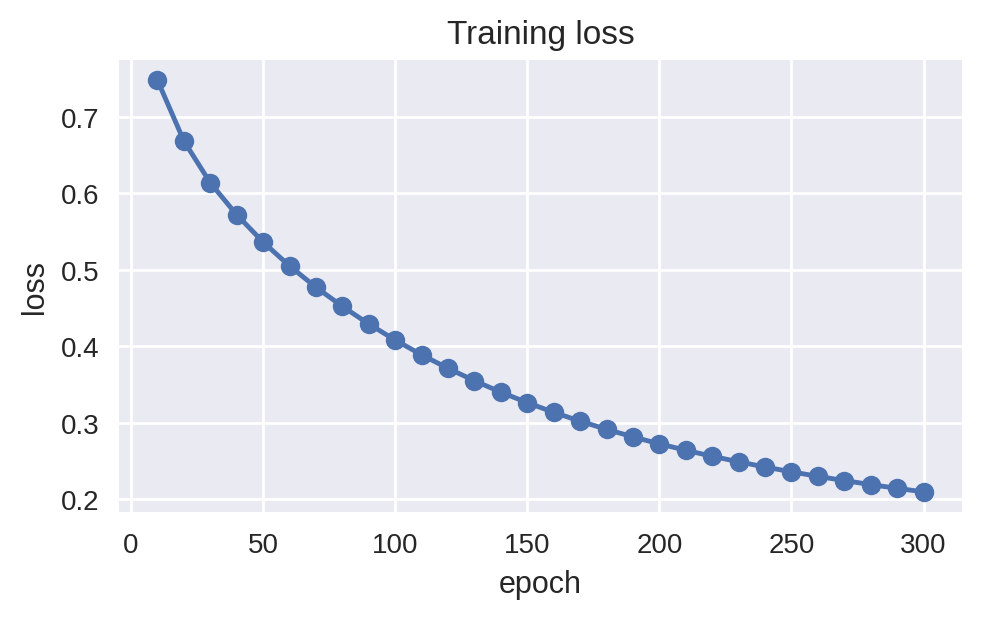

In [146]:
xs = np.arange(10, 300+1, 10)
plt.figure(figsize=(5.0, 3.2))
plt.plot(xs, losses, marker='o')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss')
plt.tight_layout(); plt.show()

## Conclusion: With 'manual forward' and PyTorch for gradients I get Accuracy as follows: with 16 neurons in layer1 a accuracy = 0.988  and with only 2 neurons accuracy = 0.82

# 3.  **PyTorch `nn.Module` (Semi-Manual)**: Defining a custom neural network using PyTorch's `nn.Module`.

In [147]:
# Core libraries for tensors, arrays, and plotting
import torch  # tensors and autograd
import numpy as np  # numerical arrays
import matplotlib.pyplot as plt  # plotting
from torch import nn  # neural network layers
plt.style.use('seaborn-v0_8')  # consistent plot style
from sklearn.datasets import make_moons  # toy dataset
from sklearn.model_selection import train_test_split  # splits
%config InlineBackend.figure_format = 'retina'  # crisp inline images

 ## TinyMLP (PyTorch Semi-Manual)

In [148]:
# Set random seed for reproducibility
np.random.seed(50) # 78

# Generate data points
# x ~ Uniform([-1, 1]^2) means both x1 and x2 are uniformly distributed in [-1, 1]
n_points = 1000
x1 = np.random.uniform(-1, 1, n_points)
x2 = np.random.uniform(-1, 1, n_points)

# Stack them to create our input data (n_points, 2)
X = np.column_stack([x1, x2])

# Generate labels using the XOR rule
# y = 1 if x1 * x2 < 0, else y = 0
y = (x1 * x2 < 0).astype(int) # (n_points, )
X.shape, y.shape

((1000, 2), (1000,))

In [149]:
# prepare data
X_tr, X_te, y_tr, y_te = train_test_split(  # stratified split
    X, y, test_size=0.25, random_state=42, stratify=y)
X_tr = torch.tensor(X_tr, dtype=torch.float32)  # train features tensor
X_te = torch.tensor(X_te, dtype=torch.float32)  # test features tensor
y_tr = torch.tensor(y_tr, dtype=torch.long)  # train labels (class indices)
y_te = torch.tensor(y_te, dtype=torch.long)  # test labels (class indices)
X_tr.shape

torch.Size([750, 2])

In [150]:
class TinyMLP(nn.Module): # Inherit from nn.Module to make this a PyTorch model
    def __init__(self, d, h):
        super().__init__()
        self.W1 = nn.Parameter(torch.randn(d, h) * 0.1) # nn.Parameter makes this tensor a trainable model parameter
        self.b1 = nn.Parameter(torch.zeros(h)) # nn.Parameter makes this tensor a trainable model parameter
        self.W2 = nn.Parameter(torch.randn(h, 2) * 0.1) # nn.Parameter makes this tensor a trainable model parameter
        self.b2 = nn.Parameter(torch.zeros(2)) # nn.Parameter makes this tensor a trainable model parameter

    def forward(self, x):
        # First layer: input -> hidden
        a1 = x @ self.W1 + self.b1
        h1 = torch.relu(a1)

        # Second layer: hidden -> output
        f = h1 @ self.W2 + self.b2
        return f

Define a loos function

In [151]:
criterion = torch.nn.CrossEntropyLoss() # nn.CrossEntropyLoss is a common loss function for multi-class classification

Train TinyMLP

In [152]:
model = TinyMLP(2, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    # Forward pass - uses my code in forward()
    output = model(X_tr)
    loss = criterion(output, y_tr)

    # Backward pass - PyTorch computes all gradients!
    optimizer.zero_grad()
    loss.backward()  # ← Magic happens here!
    optimizer.step()



Create the training loop:

Epoch [50/500], Loss: 0.0838
Epoch [100/500], Loss: 0.0660
Epoch [150/500], Loss: 0.0551
Epoch [200/500], Loss: 0.0474
Epoch [250/500], Loss: 0.0418
Epoch [300/500], Loss: 0.0373
Epoch [350/500], Loss: 0.0336
Epoch [400/500], Loss: 0.0306
Epoch [450/500], Loss: 0.0280
Epoch [500/500], Loss: 0.0258


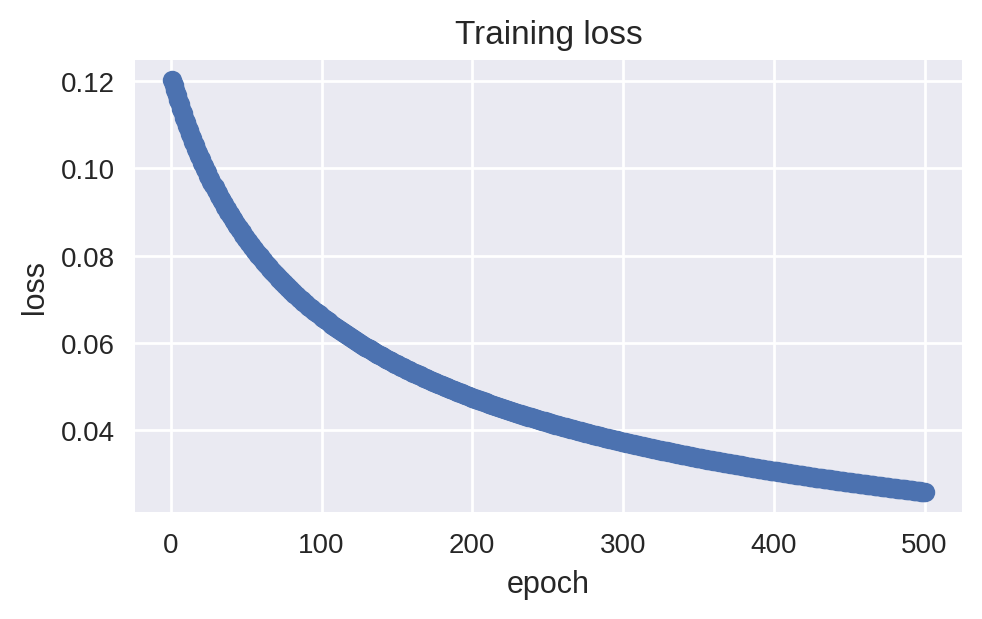

In [153]:
num_epochs = 500  # or however many iterations you want
losses_semi = [] # To store losses specifically for this semi manual model
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tr)
    loss = criterion(outputs, y_tr)

    # Backward pass
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights

    losses_semi.append(loss.item())

    # Optional: print progress
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot of losses:
xs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(5.0, 3.2))
plt.plot(xs, losses_semi, marker='o')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss')
plt.tight_layout(); plt.show()

In [154]:
with torch.no_grad():  # Don't compute gradients during evaluation
    output_logits = model(X_te)
    predicted_classes = output_logits.argmax(dim=1) # Get the index of the max logit (the predicted class)
    accuracy = (predicted_classes == y_te).float().mean() # Compare predicted classes with true labels
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9840


## Conclusion: PyTorch semi-manual loop seems to work well (here with 16 hidden units)

# 4.  **PyTorch `nn.Sequential` (Fully Automated)**: Leveraging PyTorch's `nn.Sequential` for a streamlined and automated model definition and training process.

Epoch [50/500], Loss: 0.3077, Test Accuracy: 0.9280
Epoch [100/500], Loss: 0.1478, Test Accuracy: 0.9920
Epoch [150/500], Loss: 0.0932, Test Accuracy: 0.9920
Epoch [200/500], Loss: 0.0717, Test Accuracy: 0.9880
Epoch [250/500], Loss: 0.0592, Test Accuracy: 0.9880
Epoch [300/500], Loss: 0.0506, Test Accuracy: 0.9840
Epoch [350/500], Loss: 0.0443, Test Accuracy: 0.9840
Epoch [400/500], Loss: 0.0393, Test Accuracy: 0.9840
Epoch [450/500], Loss: 0.0353, Test Accuracy: 0.9840
Epoch [500/500], Loss: 0.0320, Test Accuracy: 0.9840


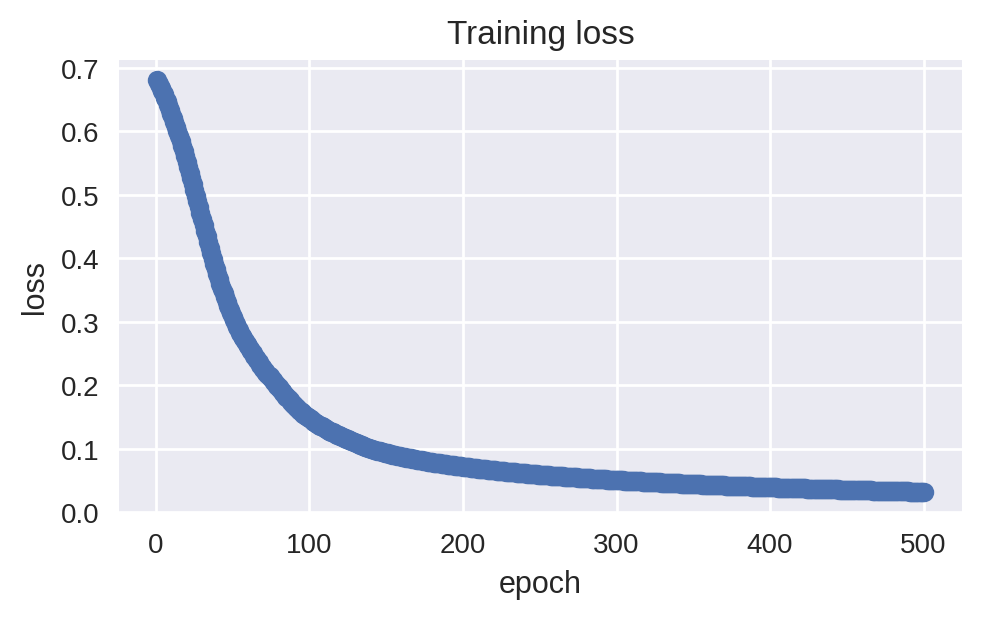

In [155]:
import torch
import torch.nn as nn

# Define network dimensions
d = 2       # input_size (from X_tr.shape[1])
h = 16      # hidden_size
d_out = 2   # output_size for binary classification (matches y_tr with 0 and 1)

# Define the nn.Sequential model
model = nn.Sequential( # nn.Sequential is a container that passes input through modules in the order they are added
    nn.Linear(d, h),   # nn.Linear applies a linear transformation: y = xA^T + b
    nn.ReLU(),         # nn.ReLU applies the Rectified Linear Unit activation function
    nn.Linear(h, d_out) # nn.Linear for the output layer, producing logits for d_out classes
)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss() # nn.CrossEntropyLoss: a loss function for multi-class classification

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
losses_sequential = [] # To store losses specifically for this sequential model

for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Forward pass
    outputs = model(X_tr)
    loss = criterion(outputs, y_tr)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights

    losses_sequential.append(loss.item())

    # Print progress and evaluate periodically
    if (epoch + 1) % 50 == 0:
        # Set model to evaluation mode
        model.eval()
        with torch.no_grad(): # Disable gradient calculation for evaluation
            output_logits = model(X_te)
            predicted_classes = output_logits.argmax(dim=1)
            accuracy = (predicted_classes == y_te).float().mean()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

# Plot of losses
xs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(5.0, 3.2))
plt.plot(xs, losses_sequential, marker='o')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss')
plt.tight_layout(); plt.show()

## Conclusion: PyTorch nn.Sequential works well and improves fast - especially at the first 100 epochs
